In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px

In [5]:
#prisijungimas prie mySQL, ir kursoriaus sukūrimas
DB = cnt.connect(
host = '88.223.121.130',
user='user',
password='slaptazodis',
port=3306,
database='works'
)
C=DB.cursor()

In [20]:
# Turite nusiskaityti iš SQL DB lentelės autopliuslt į Pandas DataFrame gamintoją, 
# kainą, pagaminimo datą, ridą, pavarų tipą, variklio informaciją. 
# SQL užklausoje turite atmesti tuos įrašus, kur rida nenurodyta, taip pat palikite 
# tik nesikartojančius įrašus (atranka pagal ID stuleplį - jei ID sutampa - reiškia, jog skelbimas dubliuojasi)
# pridėkite dar vieną stulpelį, kur būtų rida, suapvalinta 5000 km intervalais

sql="""select Gamintojas, pagaminimo_data as Data, cast(replace(price,' ','') as float) as Kaina, cast(replace(replace(rida,' ',''),'km','')as float) as Rida, pavaros as Pavaros, variklis as Variklis  from autopliuslt
where Rida <> 'Nenurodyta'
group by id;"""

# Destytojo
# #sql užklausa per pandas sql_query
# sql="""with T1
# as (select *, row_number() over (partition by id) as rc from autopliuslt)
# select gamintojas, rida, price as kaina,
# pagaminimo_data as data,
# pavaros, variklis
# from T1
# where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
# df = pd.read_sql_query(sql, con=DB)
# df.head(2)

df_ap = pd.read_sql_query(sql, con=DB)
def amz(s):
    return 2024-int(s[:4])
def rid(r):
    # return round(r/5000,0)*5000
    return np.ceil(r/5000)*5000
df_ap['R5000'] = df_ap['Rida'].apply(rid)
df_ap['Amžius'] = df_ap['Data'].apply(amz)
df_ap.head()

# Destytojo
# df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
# df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
# df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))
# df.head()

,Gamintojas,Data,Kaina,Rida,Pavaros,Variklis,R5000,Amžius
0,Mitsubishi,1996,1450.0,173810.0,Mechaninė,2500 cm³,175000.0,28
1,Isuzu,2003,850.0,186684.0,Mechaninė,3000 cm³,190000.0,21
2,Hyundai,2004,1450.0,159326.0,Mechaninė,2400 cm³,160000.0,20
3,Toyota,2008,1450.0,249449.0,Mechaninė,2200 cm³,250000.0,16
4,Mercedes-Benz,2003,1450.0,205997.0,Automatinė,2700 cm³,210000.0,21


In [ ]:
# seaborn naudojamas trendams vizualizuoti

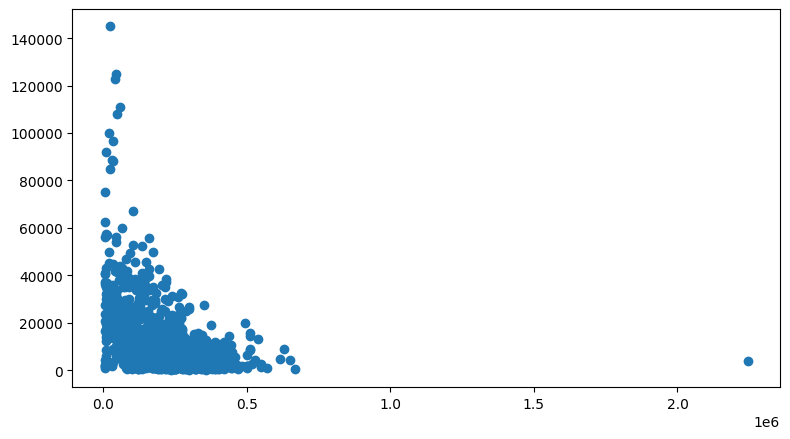

In [23]:
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(df_ap['R5000'], df_ap['Kaina'])
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show() 

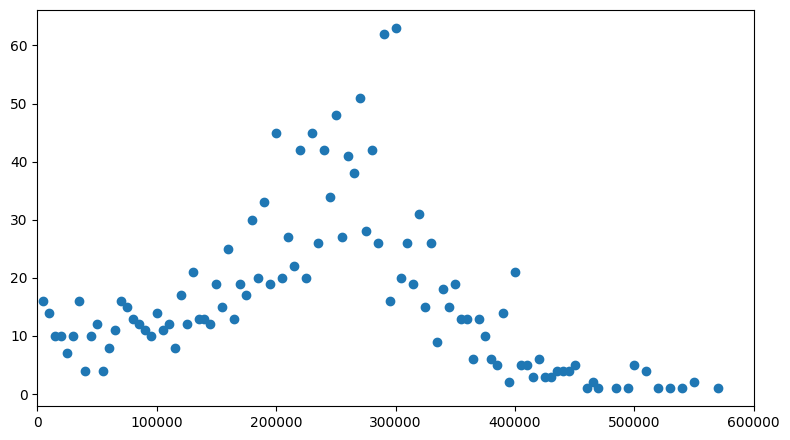

In [37]:
# groupby(), agregacijos (mean,median), reset_index() sukuria nauja indeksu stulpeli ir indeksai tampa stulpeliu
# head() su groupby()

dfg = df_ap[['R5000', 'Kaina']].groupby('R5000').count().reset_index()
dfg.head()

fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['R5000'], dfg['Kaina'])
axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

In [38]:
dfg = df_ap[['R5000', 'Kaina']].groupby('R5000').mean(numeric_only=True).reset_index()
dfg.head()

,R5000,Kaina
0,5000.0,27957.187500
1,10000.0,30702.857143
2,15000.0,23330.800000
3,20000.0,35309.000000
4,25000.0,51850.000000


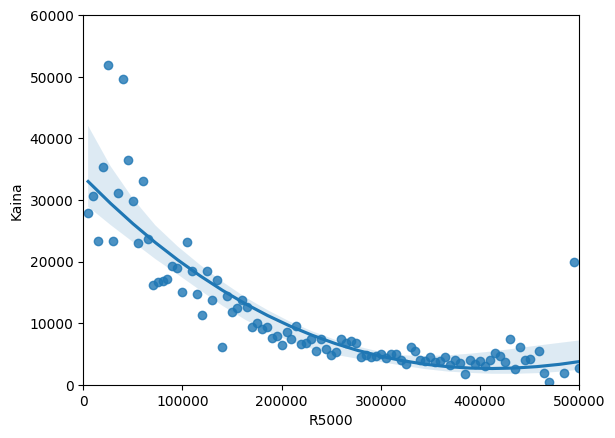

In [46]:
# seaborn regplot()


axis = sns.regplot(data=dfg, x='R5000', y='Kaina', order=3)
axis.set_xlim(0, 5e5)
axis.set_ylim(0, 6e4)
plt.show()